In [ ]:
import pandas as pd
import re
import numpy as np
import os

def parse_user_blocks(lines, user):
    user_data = []
    i = 0

    while i < len(lines):
        line = lines[i]

        # Detect start of new TimeGuessr entry
        if line.startswith("TimeGuessr"):
            m = re.search(r"TimeGuessr #(\d+)\s+[—-]?\s*([\d,]+)/50,000", line)
            if m:
                day = int(m.group(1))
                total_score = int(m.group(2).replace(",", ""))
                rounds = []
                j = i + 1

                # --- CASE 1: Emoji keycap rounds (1️⃣⃣ … 5️⃣⃣ …) ---
                # Check if next lines have the numbered emoji format
                if j < len(lines) and re.search(r"[1-5]️⃣", lines[j]) and "🏆" in lines[j]:
                    rounds_found = 0
                    k = j
                    while k < len(lines) and rounds_found < 5:
                        line_text = lines[k]
                        # Look for the numbered emoji keycap pattern with trophy
                        if re.search(r"[1-5]️⃣", line_text) and "🏆" in line_text:
                            match = re.search(
                                r"🏆(\d+)\s*-\s*📅(\d+)y\s*-\s*🌍([\d.]+\s*\w+)", 
                                line_text
                            )
                            if match:
                                round_score = int(match.group(1))
                                time_dist = int(match.group(2))
                                geo_dist = match.group(3).strip()
                                rounds.append({
                                    "Round Score": round_score,
                                    "Time Distance": time_dist,
                                    "Geography Distance": geo_dist,
                                    "Time Guessed": np.nan,
                                    "Time Score": np.nan,
                                    "Geography Score": np.nan,
                                    "Geography": np.nan,
                                    "Time": np.nan
                                })
                                rounds_found += 1
                            k += 1
                        else:
                            break
                    i = k  # move past the last parsed round

                # --- CASE 2: Detailed format with scores (Year: X. Location: Y) ---
                elif j < len(lines) and "Year:" in lines[j] and "Location:" in lines[j]:
                    for k in range(j, j + 5):
                        if k >= len(lines):
                            break
                        # Updated pattern without location guess, optional country before year
                        detailed_match = re.search(
                            r"🌎([🟩🟨⬛️]*)\s*📅([🟩🟨⬛️]*)\s+(?:([^,]+),\s*)?(\d{3,4}),\s*([\d.]+\s*\w+)\.\s*Year:\s*(\d+)\.\s*Location:\s*(\d+)",
                            lines[k]
                        )
                        if detailed_match:
                            geo = detailed_match.group(1)
                            time = detailed_match.group(2)
                            country_guessed = detailed_match.group(3)  # May be None
                            time_guessed = int(detailed_match.group(4))
                            geography_distance = detailed_match.group(5).strip()
                            time_score = int(detailed_match.group(6))
                            geography_score = int(detailed_match.group(7))
                            round_score = time_score + geography_score
                            rounds.append({
                                "Round Score": round_score,
                                "Geography Distance": geography_distance,
                                "Time Distance": np.nan,
                                "Time Guessed": time_guessed,
                                "Time Score": time_score,
                                "Geography Score": geography_score,
                                "Geography": geo,
                                "Time": time
                            })
                    i += 6

                # --- CASE 3: Ultra-simplified format (year, distance only - no scores) ---
                elif j < len(lines) and lines[j].startswith("🌎"):
                    # Check if this is the simplified format by looking for comma and distance unit
                    test_line = lines[j]
                    # More flexible check - just needs year, comma, and number before km/m
                    if re.search(r"\d{3,4},\s*[\d.]+\s*k?m", test_line) and "Year:" not in test_line:
                        for k in range(j, j + 5):
                            if k >= len(lines):
                                break
                            line_text = lines[k]
                            # Match pattern: emojis, optional country, year, distance (no scores)
                            # Handle both "km" and "m", with optional space
                            simple_match = re.search(
                                r"🌎([🟩🟨⬛️]*)\s*📅([🟩🟨⬛️]*)\s+(?:([^,]+),\s*)?(\d{3,4}),\s*([\d.]+)\s*(k?m)",
                                line_text
                            )
                            if simple_match:
                                geo = simple_match.group(1)
                                time = simple_match.group(2)
                                country_guessed = simple_match.group(3)  # May be None
                                time_guessed = int(simple_match.group(4))
                                distance_num = simple_match.group(5)
                                distance_unit = simple_match.group(6)
                                geography_distance = f"{distance_num} {distance_unit}"
                                rounds.append({
                                    "Round Score": np.nan,
                                    "Geography Distance": geography_distance,
                                    "Time Distance": np.nan,
                                    "Time Guessed": time_guessed,
                                    "Time Score": np.nan,
                                    "Geography Score": np.nan,
                                    "Geography": geo,
                                    "Time": time
                                })
                            else:
                                # Debug: if match fails, try to see what's in the line
                                print(f"Failed to match line {k}: {line_text}")
                        i += 6
                    # Otherwise fall through to CASE 4
                    else:
                        for k in range(i + 1, i + 6):
                            if k < len(lines) and lines[k].startswith("🌎"):
                                r = re.search(r"🌎([🟩🟨⬛️]*)\s+📅([🟩🟨⬛️]*)", lines[k])
                                if r:
                                    geo = r.group(1)
                                    time = r.group(2)
                                    rounds.append({
                                        "Round Score": np.nan,
                                        "Geography": geo,
                                        "Geography Distance": np.nan,
                                        "Time": time,
                                        "Time Distance": np.nan,
                                        "Time Guessed": np.nan,
                                        "Time Score": np.nan,
                                        "Geography Score": np.nan
                                    })
                        i += 6

                # (Already handled in CASE 3 else block above)

                # --- Append rounds to user_data ---
                for rnum, rd in enumerate(rounds, start=1):
                    entry = {
                        "Timeguessr Day": day,
                        "Timeguessr Round": rnum,
                        "Total Score": total_score,
                        "Round Score": rd.get("Round Score", np.nan),
                        "Geography": rd.get("Geography", np.nan),
                        "Geography Distance": rd.get("Geography Distance", np.nan),
                        "Time": rd.get("Time", np.nan),
                        "Time Distance": rd.get("Time Distance", np.nan),
                        "Time Guessed": rd.get("Time Guessed", np.nan),
                        "Time Score": rd.get("Time Score", np.nan),
                        "Geography Score": rd.get("Geography Score", np.nan),
                    }
                    user_data.append(entry)
            else:
                i += 1
        else:
            i += 1

    # Convert to DataFrame and rename columns with user prefix
    df_user = pd.DataFrame(user_data)

    for col in ["Time","Geography"]:
        df_user[col] = (
            df_user[col]
            .astype(str)
            .str.replace("🟩", "O", regex=False)
            .str.replace("🟨", "%", regex=False)
            .str.replace("⬛", "X", regex=False)
            .apply(lambda x: re.sub(r"[\uFE0F\u200Dï¸]", "", x))  # remove hidden unicode
            .str.strip()
        )

    def convert_to_meters(value):
        """Convert distance strings like '1.6 km' or '45.1 m' to float meters."""
        if pd.isna(value):
            return np.nan

        val = str(value).strip().lower()

        # Extract numeric part
        try:
            num = float(val.split()[0])
        except:
            return np.nan

        # Convert based on unit
        if "km" in val:
            return num * 1000
        elif "m" in val:
            return num
        else:
            return np.nan  # unexpected unit

    df_user["Geography Distance"] = df_user["Geography Distance"].apply(convert_to_meters)

    # Set score to 5000 for "OOO"
    mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OOO")
    df_user.loc[mask, "Geography Score"] = 5000

    # Mask for rows where score is still NaN and distance is not NaN
    mask = df_user["Geography Score"].isna() & df_user["Geography Distance"].notna()
    dist = df_user.loc[mask, "Geography Distance"]

    # Distance-based score rules
    conditions = [
        (dist <= 50),
        (dist > 50) & (dist <= 1000),
        (dist > 1000) & (dist <= 5000),
        (dist > 5000) & (dist <= 100000),
        (dist > 100000) & (dist <= 1000000),
        (dist > 1000000) & (dist <= 2000000),
        (dist > 2000000) & (dist <= 3000000),
        (dist > 3000000) & (dist <= 6000000),
        (dist > 6000000)
    ]

    scores = [
        5000,
        5000 - (dist * 0.02),
        4980 - (dist * 0.016),
        4900 - (dist * 0.004),
        4500 - (dist * 0.001),
        3500 - (dist * 0.0005),
        2500 - (dist * 0.0003333),
        1500 - (dist * 0.0002),
        12
    ]

    df_user.loc[mask, "Geography Score"] = np.select(conditions, scores, default=np.nan)
    df_user["Geography Score"] = df_user["Geography Score"].clip(lower=12)

    # Geography Score min/max
    if "Geography Score" in df_user.columns:
        df_user["Geography Score (Min)"] = np.nan
        df_user["Geography Score (Max)"] = np.nan
        
        # If geography score exists, use it for both min and max
        mask = df_user["Geography Score"].notna()
        df_user.loc[mask, "Geography Score (Min)"] = df_user.loc[mask, "Geography Score"]
        df_user.loc[mask, "Geography Score (Max)"] = df_user.loc[mask, "Geography Score"]
        
        # For missing geography scores, set min/max based on pattern
        if "Geography" in df_user.columns:
            # OO% pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OO%")
            df_user.loc[mask, "Geography Score (Min)"] = 4750
            df_user.loc[mask, "Geography Score (Max)"] = 4999
            
            # OOX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OOX")
            df_user.loc[mask, "Geography Score (Min)"] = 4500
            df_user.loc[mask, "Geography Score (Max)"] = 4749
            
            # O%X pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "O%X")
            df_user.loc[mask, "Geography Score (Min)"] = 4250
            df_user.loc[mask, "Geography Score (Max)"] = 4499
            
            # OXX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "OXX")
            df_user.loc[mask, "Geography Score (Min)"] = 3500
            df_user.loc[mask, "Geography Score (Max)"] = 4249
            
            # %XX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "%XX")
            df_user.loc[mask, "Geography Score (Min)"] = 2500
            df_user.loc[mask, "Geography Score (Max)"] = 3499
            
            # XXX pattern
            mask = df_user["Geography Score"].isna() & (df_user["Geography"] == "XXX")
            df_user.loc[mask, "Geography Score (Min)"] = 12
            df_user.loc[mask, "Geography Score (Max)"] = 2499

    df_user = df_user.rename(columns={
        "Total Score": f"{user} Total Score",
        "Round Score": f"{user} Round Score",
        "Geography": f"{user} Geography",
        "Geography Distance": f"{user} Geography Distance",
        "Time": f"{user} Time",
        "Time Distance": f"{user} Time Distance",
        "Time Guessed": f"{user} Time Guessed",
        "Time Score": f"{user} Time Score",
        "Geography Score": f"{user} Geography Score",
        "Geography Score (Min)": f"{user} Geography Score (Min)",
        "Geography Score (Max)": f"{user} Geography Score (Max)"
    })

    return df_user


def parse_actuals(lines):
    actuals_data = []
    i = 0

    while i < len(lines):
        line = lines[i]

        # Detect start of TimeGuessr day
        if line.startswith("TimeGuessr #"):
            m = re.search(r"TimeGuessr #(\d+)", line)
            if m:
                day = int(m.group(1))

                # Parse the next 5 rounds
                for round_num in range(1, 6):
                    i += 1
                    if i < len(lines):
                        # Match pattern: "1. London, United Kingdom, 1970"
                        round_match = re.search(
                            r"^\d+\.\s+(.+?),\s+(.+?),\s+(\d{4})$",
                            lines[i]
                        )
                        if round_match:
                            city = round_match.group(1).strip()
                            country = round_match.group(2).strip()
                            year = int(round_match.group(3))

                            # --- Extract subdivision if city has parentheses ---
                            subdivision_match = re.search(r"\((.*?)\)", city)
                            if subdivision_match:
                                subdivision = subdivision_match.group(1).strip()
                                city = re.sub(r"\s*\(.*?\)", "", city).strip()
                            else:
                                subdivision = ""

                            actuals_data.append({
                                "Timeguessr Day": day,
                                "Timeguessr Round": round_num,
                                "City": city,
                                "Subdivision": subdivision,
                                "Country": country,
                                "Year": year
                            })
        i += 1

    return pd.DataFrame(actuals_data)


# --- Check if parsed CSVs already exist ---
michael_csv = "Data/Timeguessr_Michael_Parsed.csv"
sarah_csv   = "Data/Timeguessr_Sarah_Parsed.csv"
actuals_csv = "Data/Timeguessr_Actuals_Parsed.csv"

print("🔄 Parsed CSVs not found — parsing from TXT files...")

# --- Load user files ---
with open("Data/TimeGuessr_Michael.txt", "r", encoding="utf-8") as f:
    michael_lines = [line.strip() for line in f if line.strip()]

with open("Data/TimeGuessr_Sarah.txt", "r", encoding="utf-8") as f:
    sarah_lines = [line.strip() for line in f if line.strip()]

with open("Data/TimeGuessr_Actuals.txt", "r", encoding="utf-8") as f:
    actuals_lines = [line.strip() for line in f if line.strip()]

# --- Parse both users ---
df_michael = parse_user_blocks(michael_lines, "Michael")
df_michael.to_csv(michael_csv, index=False)

df_sarah = parse_user_blocks(sarah_lines, "Sarah")
df_sarah.to_csv(sarah_csv, index=False)

df_actuals = parse_actuals(actuals_lines)
df_actuals.to_csv(actuals_csv, index=False)

# --- Merge into one dataframe ---
df_all = pd.merge(df_michael, df_sarah, on=["Timeguessr Day", "Timeguessr Round"], how="outer")
df_all = pd.merge(df_all, df_actuals, on=["Timeguessr Day", "Timeguessr Round"], how="left")

# --- Calculate Time Distance if not already present ---
# For Michael
if "Michael Time Distance" in df_all.columns and "Michael Time Guessed" in df_all.columns:
    mask = df_all["Michael Time Distance"].isna() & df_all["Michael Time Guessed"].notna() & df_all["Year"].notna()
    df_all.loc[mask, "Michael Time Distance"] = abs(df_all.loc[mask, "Year"] - df_all.loc[mask, "Michael Time Guessed"])

# For Sarah
if "Sarah Time Distance" in df_all.columns and "Sarah Time Guessed" in df_all.columns:
    mask = df_all["Sarah Time Distance"].isna() & df_all["Sarah Time Guessed"].notna() & df_all["Year"].notna()
    df_all.loc[mask, "Sarah Time Distance"] = abs(df_all.loc[mask, "Year"] - df_all.loc[mask, "Sarah Time Guessed"])

# --- Add Date column first ---
start_date = pd.Timestamp("2025-03-20")
df_all["Date"] = start_date + pd.to_timedelta(df_all["Timeguessr Day"] - df_all["Timeguessr Day"].min(), unit="D")

# Move Date to first column, keep City, Country, Year early
cols = ["Date", "Timeguessr Day", "Timeguessr Round", "City", "Subdivision", "Country", "Year"] + [c for c in df_all.columns if c not in ["Date", "Timeguessr Day", "Timeguessr Round", "City", "Subdivision",  "Country", "Year"]]
df_all = df_all[cols]

# Sort and reset
df_all = df_all.sort_values(["Timeguessr Day", "Timeguessr Round"]).reset_index(drop=True)

# Handle Time scores
for player in ["Michael", "Sarah"]:
    time_col = f"{player} Time"
    time_score_col = f"{player} Time Score"
    time_dist_col = f"{player} Time Distance"
    
    # Set score to 5000 for "OOO"
    mask = df_all[time_score_col].isna() & (df_all[time_col] == "OOO")
    df_all.loc[mask, time_score_col] = 5000
    
    # Set score to 1000 for "%XX"
    mask = df_all[time_score_col].isna() & (df_all[time_col] == "%XX")
    df_all.loc[mask, time_score_col] = 1000
    
    # Set score to 0 for "XXX"
    mask = df_all[time_score_col].isna() & (df_all[time_col] == "XXX")
    df_all.loc[mask, time_score_col] = 0

    def calc_time_score(yearsOff):
        if pd.isna(yearsOff):
            return None
        yearsOff = float(yearsOff)

        if yearsOff == 0:
            return 5000
        elif yearsOff == 1:
            return 4950
        elif yearsOff == 2:
            return 4800
        elif yearsOff == 3:
            return 4600
        elif yearsOff == 4:
            return 4300
        elif yearsOff == 5:
            return 3900
        elif yearsOff in [6, 7]:
            return 3400
        elif yearsOff in [8, 9, 10]:
            return 2500
        elif 10 < yearsOff < 16:
            return 2000
        elif 15 < yearsOff < 21:
            return 1000
        else:
            return 0
        
    # Apply the conversion
    mask = df_all[time_score_col].isna()  # only fill if not already set by OOO/%XX/XXX
    df_all.loc[mask, time_score_col] = df_all.loc[mask, time_dist_col].apply(calc_time_score)
    
# --- Add min/max columns for Time and Geography scores ---
for player in ["Michael", "Sarah"]:
    # Time Score min/max
    time_score_col = f"{player} Time Score"
    time_col = f"{player} Time"
    time_min_col = f"{player} Time Score (Min)"
    time_max_col = f"{player} Time Score (Max)"
    
    if time_score_col in df_all.columns:
        df_all[time_min_col] = np.nan
        df_all[time_max_col] = np.nan
        
        # If time score exists, use it for both min and max
        mask = df_all[time_score_col].notna()
        df_all.loc[mask, time_min_col] = df_all.loc[mask, time_score_col]
        df_all.loc[mask, time_max_col] = df_all.loc[mask, time_score_col]
        
        # For missing time scores, set min/max based on pattern
        if time_col in df_all.columns:
            # OO% pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "OO%")
            df_all.loc[mask, time_min_col] = 4800
            df_all.loc[mask, time_max_col] = 4950
            
            # OOX pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "OOX")
            df_all.loc[mask, time_min_col] = 4300
            df_all.loc[mask, time_max_col] = 4600
            
            # O%X pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "O%X")
            df_all.loc[mask, time_min_col] = 3400
            df_all.loc[mask, time_max_col] = 3900
            
            # OXX pattern
            mask = df_all[time_score_col].isna() & (df_all[time_col] == "OXX")
            df_all.loc[mask, time_min_col] = 2000
            df_all.loc[mask, time_max_col] = 2500   

# --- Fill missing Round Scores if both component scores exist ---
for player in ["Michael", "Sarah"]:
    time_col = f"{player} Time Score"
    geo_col = f"{player} Geography Score"
    round_col = f"{player} Round Score"

    if all(c in df_all.columns for c in [time_col, geo_col, round_col]):
        mask = df_all[round_col].isna() & df_all[time_col].notna() & df_all[geo_col].notna()
        df_all.loc[mask, round_col] = df_all.loc[mask, time_col] + df_all.loc[mask, geo_col]

# --- Save ---
df_all.to_csv("Data/Timeguessr_Stats.csv", index=False)
print("✅ Saved combined stats to Timeguessr_Stats.csv")

df_all

🔄 Parsed CSVs not found — parsing from TXT files...
✅ Saved combined stats to Timeguessr_Stats.csv


,Date,Timeguessr Day,Timeguessr Round,City,Subdivision,Country,Year,Michael Total Score,Michael Round Score,Michael Geography,...,Sarah Time Distance,Sarah Time Guessed,Sarah Time Score,Sarah Geography Score,Sarah Geography Score (Min),Sarah Geography Score (Max),Michael Time Score (Min),Michael Time Score (Max),Sarah Time Score (Min),Sarah Time Score (Max)
0,2025-03-20,658,1,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,2500.0,NaN,NaN
1,2025-03-20,658,2,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,5000.0,NaN,NaN
2,2025-03-20,658,3,NaN,NaN,NaN,NaN,40428.0,NaN,OXX,...,NaN,NaN,NaN,NaN,NaN,NaN,4800.0,4950.0,NaN,NaN
3,2025-03-20,658,4,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,4800.0,4950.0,NaN,NaN
4,2025-03-20,658,5,NaN,NaN,NaN,NaN,40428.0,NaN,OO%,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
875,2026-02-24,999,1,Miami,Florida,United States,1979.0,38018.0,7319.600,OO%,...,14.0,1965.0,2000.0,2684.500,2684.500,2684.500,2500.0,2500.0,2000.0,2000.0
876,2026-02-24,999,2,Prague,,Czechia,1960.0,38018.0,4998.628,OO%,...,24.0,1984.0,0.0,4987.636,4987.636,4987.636,0.0,0.0,0.0,0.0
877,2026-02-24,999,3,Machu Picchu,,Peru,2016.0,38018.0,9797.000,OO%,...,2.0,2018.0,4800.0,4990.700,4990.700,4990.700,4800.0,4800.0,4800.0,4800.0
878,2026-02-24,999,4,Brussels,,Belgium,1980.0,38018.0,8444.000,OOX,...,10.0,1990.0,2500.0,4713.200,4713.200,4713.200,3900.0,3900.0,2500.0,2500.0


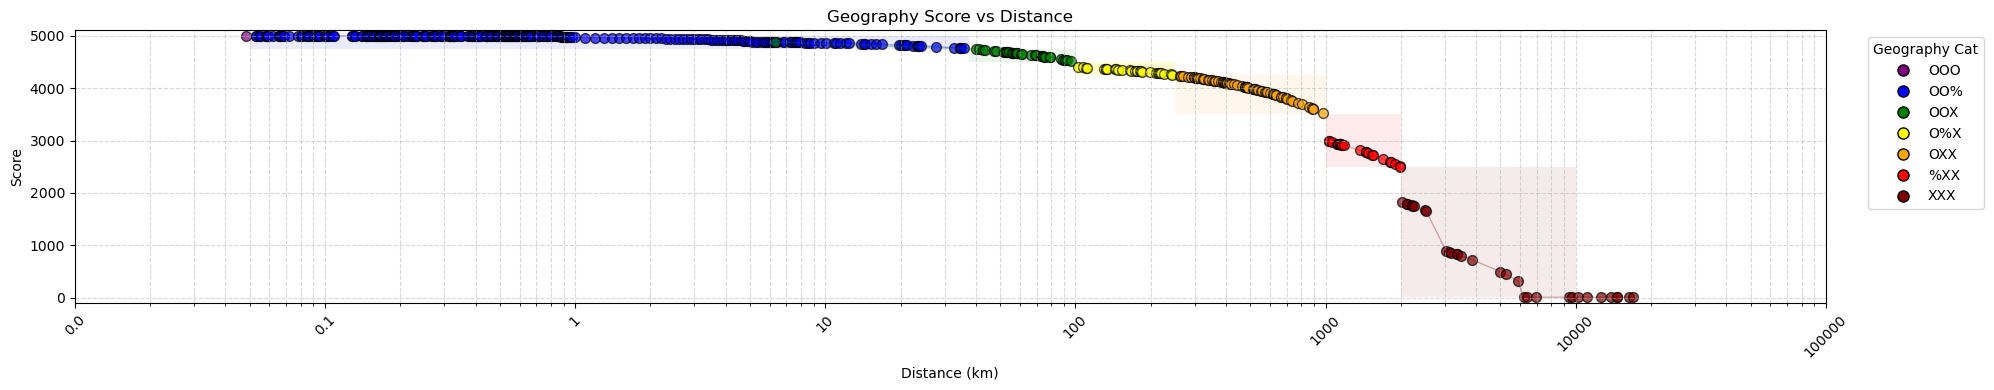

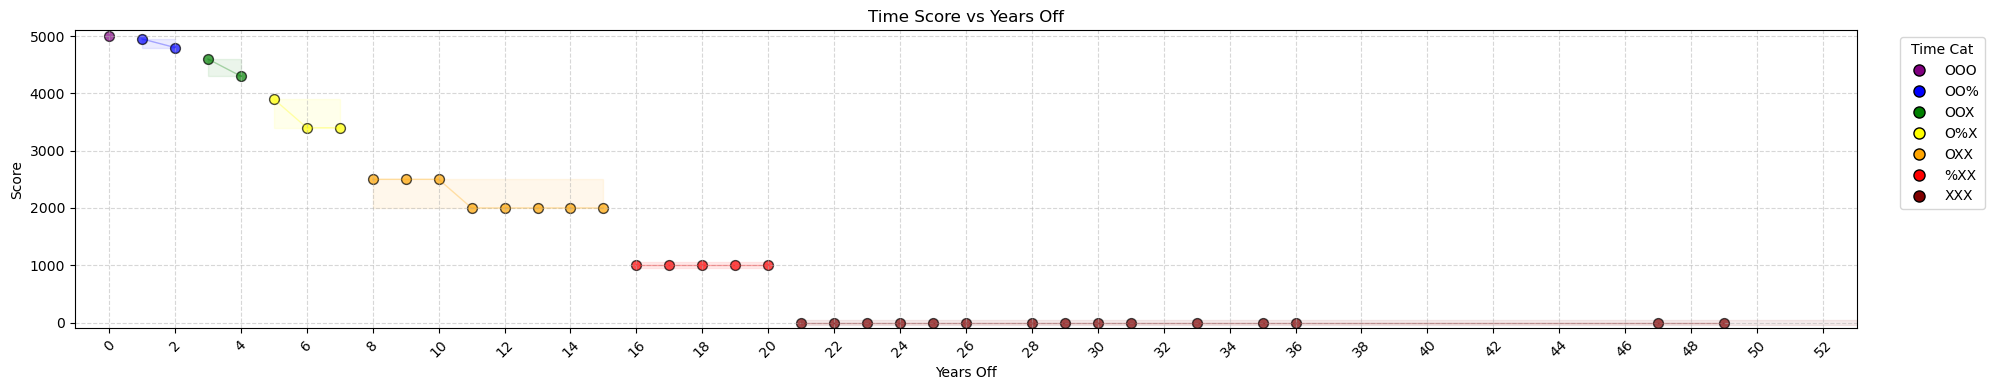

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.lines as mlines
from matplotlib.patches import Rectangle


# --- Helper to clean distances ---
def clean_distance(series):
    s = series.astype(str).str.strip().str.lower()
    s_num = s.str.extract(r'([\d\.]+)')[0].astype(float)
    s_num[s.str.contains("km", na=False)] *= 1000
    return s_num


# --- Define fixed category order and colors ---
pattern_order = ["OOO", "OO%", "OOX", "O%X", "OXX", "%XX", "XXX"]
pattern_colors = {
    "OOO": "purple",
    "OO%": "blue",
    "OOX": "green",
    "O%X": "yellow",
    "OXX": "orange",
    "%XX": "red",
    "XXX": "maroon"
}


# --- Scatter + line for Geography (log scale, fixed legend/colors) ---
def plot_geography_score_vs_distance_unique(df, score_col, distance_col_prefix, title):
    df_geo = pd.DataFrame({
        "Score": pd.concat([df[f"Michael {score_col}"], df[f"Sarah {score_col}"]], ignore_index=True),
        "Distance": pd.concat([df[f"Michael {distance_col_prefix}"], df[f"Sarah {distance_col_prefix}"]], ignore_index=True),
        "Cat": pd.concat([df["Michael Geography"], df["Sarah Geography"]], ignore_index=True)
    })

    df_geo["Distance_km"] = clean_distance(df_geo["Distance"]) / 1000
    df_geo = df_geo.dropna(subset=["Score", "Distance_km", "Cat"])
    df_geo = df_geo[df_geo["Distance_km"] > 0]

    df_plot = df_geo.groupby(["Cat", "Distance_km"], as_index=False).mean().sort_values("Distance_km")

    # Keep only one instance of 5000 (largest distance)
    if (df_plot["Score"] == 5000).any():
        max_dist_5000 = df_plot.loc[df_plot["Score"] == 5000, "Distance_km"].max()
        df_plot = df_plot[(df_plot["Score"] != 5000) | (df_plot["Distance_km"] == max_dist_5000)]

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.set_xscale("log")
    ax.set_xlabel("Distance (km)")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(True, which="both", linestyle='--', alpha=0.5)

    # --- Background shading by score tiers ---
    shade_rules = [
        (4750, 4999, "blue"),     # 🟩🟩🟨
        (4500, 4749, "green"),    # 🟩🟩⬛️
        (4250, 4499, "yellow"),   # 🟩🟨⬛️
        (3500, 4249, "orange"),   # 🟩⬛️⬛️
        (2500, 3499, "red"),      # 🟨⬛️⬛️
        (12, 2499, "maroon")       # ⬛️⬛️⬛️
    ]

    for ymin, ymax, color in shade_rules:
        if color == "blue":
            rect = Rectangle(
                (0.05, ymin), 
                37.5 - 0.05, 
                ymax - ymin,
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "green":
            rect = Rectangle(
                (37.5, ymin),
                100 - 37.5,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "yellow":
            rect = Rectangle(
                (100, ymin),
                250 - 100,
                ymax - ymin, 
                facecolor=color,
                alpha=0.18,
                zorder=0
            )
        elif color == "orange":
            rect = Rectangle(
                (250, ymin),
                1000 - 250,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "red":
            rect = Rectangle(
                (1000, ymin),
                2000 - 1000,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        elif color == "maroon":
            rect = Rectangle(
                (2000, ymin),
                10000 - 2000,
                ymax - ymin, 
                facecolor=color,
                alpha=0.08,
                zorder=0
            )
        ax.add_patch(rect)

    # --- Plot each category ---
    for cat in pattern_order:
        color = pattern_colors[cat]
        sub = df_plot[df_plot["Cat"] == cat]
        if not sub.empty:
            ax.scatter(sub["Distance_km"], sub["Score"], s=50, edgecolor='k', color=color, alpha=0.7)
            ax.plot(sub["Distance_km"], sub["Score"], color=color, alpha=0.3, linewidth=1)
        else:
            ax.scatter([], [], color=color, label=cat)

    # Log tick formatting (decimal below 1)
    min_x = max(df_plot["Distance_km"].min(), 0.001)
    max_x = df_plot["Distance_km"].max()
    log_min = int(np.floor(np.log10(min_x)))
    log_max = int(np.ceil(np.log10(max_x)))
    ticks = [10 ** i for i in range(log_min, log_max + 1)]
    tick_labels = [f"{t:.1f}" if t < 1 else f"{int(t)}" for t in ticks]
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels, rotation=45)

    ax.set_ylim(-100, 5100)

    # Custom legend handles (circles only)
    handles = [
        mlines.Line2D([], [], color=pattern_colors[cat], marker='o', linestyle='None',
                      markersize=8, label=cat, markeredgecolor='k')
        for cat in pattern_order
    ]

    ax.legend(handles=handles, title="Geography Cat", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# --- Scatter + line for Time (linear scale, fixed legend/colors) ---
def plot_time_score_vs_distance_unique(df, score_col, distance_col_prefix, title):
    df_time = pd.DataFrame({
        "Score": pd.concat([df[f"Michael {score_col}"], df[f"Sarah {score_col}"]], ignore_index=True),
        "YearsOff": pd.concat([df[f"Michael {distance_col_prefix}"], df[f"Sarah {distance_col_prefix}"]], ignore_index=True),
        "Cat": pd.concat([df["Michael Time"], df["Sarah Time"]], ignore_index=True)
    })

    df_time["YearsOff"] = pd.to_numeric(df_time["YearsOff"], errors="coerce")
    df_time = df_time.dropna(subset=["Score", "YearsOff", "Cat"])

    df_plot = df_time.groupby(["Cat", "YearsOff"], as_index=False).mean().sort_values("YearsOff")

    fig, ax = plt.subplots(figsize=(20, 4))
    ax.set_xlabel("Years Off")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)

    # --- Background shading by score tiers (calcTime rules) ---
    # approximate intervals derived from your discrete values
    # --- Axis setup before shading (so we know the full X range) ---
    max_year = int(np.ceil(df_plot["YearsOff"].max() / 2) * 2) + 2
    x_buffer = 0.02 * max_year
    ax.set_xlim(-x_buffer, max_year + x_buffer)
    ax.set_ylim(-100, 5100)

    # --- Background shading by score tiers (calcTime rules) ---
    shade_rules = [
        (4800, 4950, "blue"),
        (4300, 4600, "green"),
        (3400, 3900, "yellow"),
        (2000, 2500, "orange"),
        (950, 1050, "red"),
        (-50, 50, "maroon")
    ]
    x_min, x_max = ax.get_xlim()

    for ymin, ymax, color in shade_rules:
        if color == "blue":
            ax.axhspan(ymin, ymax, xmin=(1 - x_min) / (x_max - x_min), xmax=(2 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "green":
            ax.axhspan(ymin, ymax, xmin=(3 - x_min) / (x_max - x_min), xmax=(4 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "yellow":
            ax.axhspan(ymin, ymax, xmin=(5 - x_min) / (x_max - x_min), xmax=(7 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "orange":
            ax.axhspan(ymin, ymax, xmin=(8 - x_min) / (x_max - x_min), xmax=(15 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "red":
            ax.axhspan(ymin, ymax, xmin=(16 - x_min) / (x_max - x_min), xmax=(20 - x_min) / (x_max - x_min),
                       color=color, alpha=0.08, zorder=0)
        elif color == "maroon":
            ax.axhspan(ymin, ymax, xmin=(21 - x_min) / (x_max - x_min), xmax=1.0,
                       color=color, alpha=0.08, zorder=0)
        else:
            ax.axhspan(ymin, ymax, color=color, alpha=0.08, zorder=0)



    # --- Plot each category ---
    for cat in pattern_order:
        color = pattern_colors[cat]
        sub = df_plot[df_plot["Cat"] == cat]
        if not sub.empty:
            ax.scatter(sub["YearsOff"], sub["Score"], s=50, edgecolor='k', color=color, alpha=0.7)
            ax.plot(sub["YearsOff"], sub["Score"], color=color, alpha=0.3, linewidth=1)
        else:
            ax.scatter([], [], color=color, label=cat)

    # --- Axis formatting ---
    max_year = int(np.ceil(df_plot["YearsOff"].max() / 2) * 2) + 2
    ax.set_xticks(np.arange(0, max_year + 1, 2))
    ax.set_xticklabels(np.arange(0, max_year + 1, 2), rotation=45)

    x_buffer = 0.02 * max_year
    ax.set_xlim(-x_buffer, max_year + x_buffer)
    ax.set_ylim(-100, 5100)

    # --- Custom legend (circles only) ---
    handles = [
        mlines.Line2D([], [], color=pattern_colors[cat], marker='o', linestyle='None',
                      markersize=8, label=cat, markeredgecolor='k')
        for cat in pattern_order
    ]
    ax.legend(handles=handles, title="Time Cat", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# --- Run plots ---
plot_geography_score_vs_distance_unique(df_all, "Geography Score", "Geography Distance", "Geography Score vs Distance")
plot_time_score_vs_distance_unique(df_all, "Time Score", "Time Distance", "Time Score vs Years Off")


In [29]:
# --- Perfect score summary by player with percentages ---
data = []

for player in ["Michael", "Sarah"]:
    time_score_col = f"{player} Time Score"
    geo_score_col = f"{player} Geography Score"
    round_score_col = f"{player} Round Score"
    total_col = f"{player} Total Score"

    # Denominator: rounds where player has a total score (i.e., played)
    total_rounds = df_all[total_col].notna().sum()

    # Numerators: perfect score counts
    time_count = (df_all[time_score_col] == 5000).sum()
    geo_count = (df_all[geo_score_col] == 5000).sum()
    round_count = (df_all[round_score_col] == 10000).sum()

    # Percentages
    time_pct = time_count / total_rounds * 100 if total_rounds else np.nan
    geo_pct = geo_count / total_rounds * 100 if total_rounds else np.nan
    round_pct = round_count / total_rounds * 100 if total_rounds else np.nan

    data.append({
        "Player": player,
        "Time = 5000": time_count,
        "Time %": f"{time_pct:.1f}%",
        "Geography = 5000": geo_count,
        "Geography %": f"{geo_pct:.1f}%",
        "Round = 10000": round_count,
        "Round %": f"{round_pct:.1f}%"
    })

perfect_summary = pd.DataFrame(data)
perfect_summary


,Player,Time = 5000,Time %,Geography = 5000,Geography %,Round = 10000,Round %
0,Michael,159,18.7%,95,11.2%,30,3.5%
1,Sarah,107,14.3%,62,8.3%,16,2.1%


In [30]:
import geopandas as gpd
import pandas as pd
import os
import country_converter as coco

# --- Configuration ---
INPUT_FILE = "./Data/World_Administrative_Divisions.geojson"
OUTPUT_FILE = "./Data/Custom_World_Map.geojson"

# List of Countries to KEEP subdivisions for (ISO Alpha-3 Codes)
# Added: China, India, Spain, Italy, Mexico, Brazil, Pakistan, Poland, Argentina
COUNTRIES_TO_KEEP_SPLIT = [
    'USA', 'GBR', 'FRA', 'DEU', 'CAN', 'AUS', 
    'CHN', 'IND', 'ESP', 'ITA', 'MEX', 'BRA', 
    'PAK', 'POL', 'ARG', 'BEL', 'CHE', 'NOR',
    'NLD', 'GRC', 'JPN'
]

def process_map():
    # 1. Check file existence
    if not os.path.exists(INPUT_FILE):
        print(f"❌ Error: Input file not found at {INPUT_FILE}")
        return

    print(f"READING: {INPUT_FILE}...")
    try:
        gdf = gpd.read_file(INPUT_FILE)
    except Exception as e:
        print(f"❌ Error reading file: {e}")
        return

    print(f"✅ Loaded {len(gdf)} rows.")
    
    # 2. Standardization: Create 'ISO3' column
    # The file has 'ISO_CC' (2-letter) or 'COUNTRY' (Name). We need 'ISO3'.
    if 'ISO3' not in gdf.columns:
        print("PROCESSING: Generating standard ISO3 codes...")
        
        # Prefer ISO_CC (2-letter code) if available, else Country Name
        source_col = 'ISO_CC' if 'ISO_CC' in gdf.columns else 'COUNTRY'
        
        if source_col not in gdf.columns:
            print(f"❌ Error: Could not find 'ISO_CC' or 'COUNTRY' to generate ISO3 codes.")
            print(f"Columns found: {list(gdf.columns)}")
            return

        # Convert
        # We fill NaNs with a placeholder to prevent errors
        names = gdf[source_col].fillna('Unknown').tolist()
        gdf['ISO3'] = coco.convert(names=names, to='ISO3', not_found=None)
        
    country_col = 'ISO3'
    print("✅ ISO3 column ready.")

    # 3. Filter Data
    print(f"PROCESSING: Keeping subdivisions for {COUNTRIES_TO_KEEP_SPLIT}...")

    # A. Rows for countries we want to keep SPLIT
    gdf_split = gdf[gdf[country_col].isin(COUNTRIES_TO_KEEP_SPLIT)].copy()

    # B. Rows for countries we want to DISSOLVE
    gdf_dissolve_source = gdf[~gdf[country_col].isin(COUNTRIES_TO_KEEP_SPLIT)].copy()

    print(f"   - Rows to keep split: {len(gdf_split)}")
    print(f"   - Rows to dissolve:   {len(gdf_dissolve_source)}")

    # 4. Perform Dissolve
    # This merges all geometries sharing the same ISO3 into one polygon
    if not gdf_dissolve_source.empty:
        print("DISSOLVING: Merging borders for the rest of the world...")
        # We dissolve by ISO3. 
        # as_index=False keeps ISO3 as a column.
        gdf_dissolved = gdf_dissolve_source.dissolve(by=country_col, as_index=False)
    else:
        gdf_dissolved = gpd.GeoDataFrame()

    # 5. Combine and Save
    print("COMBINING: merging layers...")
    
    # Ensure both have the same CRS (Coordinate Reference System) just in case, though they come from same source
    gdf_final = pd.concat([gdf_split, gdf_dissolved], ignore_index=True)

    # Clean up: Ensure we have the columns the main app expects
    # The main app looks for 'ISO3' and 'NAME' (for subdivisions). 
    # Your file has 'NAME', so we are good. 
    
    print(f"WRITING: Saving to {OUTPUT_FILE}...")
    try:
        gdf_final.to_file(OUTPUT_FILE, driver='GeoJSON')
        print("✅ Done! File saved.")
    except Exception as e:
        print(f"❌ Error writing file: {e}")

if __name__ == "__main__":
    process_map()

READING: ./Data/World_Administrative_Divisions.geojson...
✅ Loaded 5824 rows.
PROCESSING: Generating standard ISO3 codes...


X1 not found in ISO2


✅ ISO3 column ready.
PROCESSING: Keeping subdivisions for ['USA', 'GBR', 'FRA', 'DEU', 'CAN', 'AUS', 'CHN', 'IND', 'ESP', 'ITA', 'MEX', 'BRA', 'PAK', 'POL', 'ARG', 'BEL', 'CHE', 'NOR', 'NLD', 'GRC', 'JPN']...
   - Rows to keep split: 1000
   - Rows to dissolve:   4824
DISSOLVING: Merging borders for the rest of the world...
COMBINING: merging layers...
WRITING: Saving to ./Data/Custom_World_Map.geojson...
✅ Done! File saved.
